##### 제3회 국민대학교 AI 빅데이터 분석 경진대회
- 무역 품목 간 공행성 쌍 판별 및 후행 품목 무역량 예측
---
- **item_id:** 무역품 식별 ID
- **year:** 년
- **month:** 월
- **seq:** 동일 년-월 내 일련번호
- **type:** 유형 구분 코드
- **hs4:** HS4 코드 (각 품목이 어떤 항목에 속하는지 알려줌), HS2 세분화 -> HS4
- **weight:** 중량
- **quantity:** 수량
- **value:** 무역량 (정수형)
---
1. 공행성 쌍 추출
2. 후행 품목 무역량 예측
---
1. baseline lag=6 : 0.32
2. baseline lag=12 : 0.34

----
- min_nonzero = 36, 39 각각 확인

In [1]:
# 라이브러리 import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 크롤링을 위한 import
import requests
from io import StringIO


In [2]:
# data load
df = pd.read_csv('./train.csv')
df.head()

,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0


In [3]:
# 피처 및 데이터 타입
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB


In [4]:
df.describe()

,year,month,seq,type,hs4,weight,quantity,value
count,10836.000000,10836.000000,10836.000000,10836.0,10836.000000,1.083600e+04,1.083600e+04,1.083600e+04
mean,2023.331395,6.108435,2.034238,1.0,4821.969546,1.098413e+06,8.633771e+04,1.739442e+06
std,1.049357,3.392649,0.813380,0.0,2296.892536,5.153790e+06,7.614669e+06,5.457480e+06
min,2022.000000,1.000000,1.000000,1.0,1210.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022.000000,3.000000,1.000000,1.0,2833.000000,3.457500e+02,0.000000e+00,1.150675e+04
50%,2023.000000,6.000000,2.000000,1.0,3824.000000,6.532500e+03,0.000000e+00,1.250070e+05
75%,2024.000000,9.000000,3.000000,1.0,7202.000000,1.555108e+05,0.000000e+00,1.039764e+06
max,2025.000000,12.000000,3.000000,1.0,9403.000000,1.104919e+08,7.925990e+08,1.110414e+08


In [5]:
# 결측값 확인
df.isnull().sum()

item_id     0
year        0
month       0
seq         0
type        0
hs4         0
weight      0
quantity    0
value       0
dtype: int64

In [6]:
# 각 피처의 unique 개수 확인
print(f'df shape: {df.shape}\n')

unique_items = df['item_id'].nunique() # 고유 item_id 개수
print(f'unique items: {unique_items}\n')

years = df['year'].unique() # 연도
print(f'unique years: {years}\n')

month = df['month'].unique() # 월
print(f'unique month: {month}\n')

seq = df['seq'].unique() # 일련번호
print(f'unique seq: {seq}\n')

Type = df['type'].unique() # 유형
print(f'unique type: {Type}\n')

hs4 = df['hs4'].unique() # HS4
print(f'length unique hs4: {len(hs4)}')
print(f'unique hs4: {hs4}')
# weight, quantity, value 제외

df shape: (10836, 9)

unique items: 100

unique years: [2022 2023 2024 2025]

unique month: [ 1  2  3  4  5  6  7  8  9 10 11 12]

unique seq: [1. 2. 3.]

unique type: [1]

length unique hs4: 71
unique hs4: [3038 2002 2102 2501 2529 2805 2807 2811 2814 2825 2833 2836 2841 2846
 2847 2916 3006 3102 3206 3207 3215 3307 3404 3806 3815 3824 3904 3909
 4202 4601 4802 5111 5205 5309 5402 5515 5602 5609 5705 6101 6211 7202
 7207 8102 8105 8461 8467 8479 8501 8505 8527 8708 8714 9403 1210 3813
 4408 4810 5512 2701 7907 2710 6006 5119 9022 4403 3003 2612 4302 7142
 3024]


In [7]:
# 크롤링을 통한 HS 코드에 따른 2단위, 4단위 한글명 매칭

def requests_name(url, headers):
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    tables = pd.read_html(StringIO(response.text))
    hs_df = tables[0]
    hs_df.columns = hs_df.columns.get_level_values(1)
    return hs_df

# URL 및 헤더 설정
base_url = "https://okfta.kita.net/hsCode?pageIndex=1&mnSn=207&scGbn=all&scKwrd="
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

for code1 in list(map(str, hs4)):
    code2 = f'0{code1[:-1]}.{code1[-1]}'
    url1 = f'{base_url}{code1}'
    url2 = f'{base_url}{code2}'

    hs_df = requests_name(url1, headers)

    if hs_df.loc[0, '2단위'] == '검색결과가 없습니다.':
        hs_df = requests_name(url2, headers)

    df.loc[df['hs4'] == int(code1), '2단위'] = hs_df.loc[0, '2단위']
    df.loc[df['hs4'] == int(code1), '4단위'] = hs_df.loc[0, '4단위']

df.head()

,item_id,year,month,seq,type,hs4,weight,quantity,value,2단위,4단위
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,제3류 어류ㆍ갑각류ㆍ연체동물과 그 밖의 수생(水生) 무척추동물,냉동어류[제0304호의 어류의 필레(fillet)와 기타 어육은 제외한다]
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,제20류 채소ㆍ과실ㆍ견과류나 식물의그 밖의 부분의 조제품,조제하거나 보존처리한 토마토(식초나 초산으로 처리한 것은 제외한다)
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,제21류 각종 조제 식료품,"효모(활성이거나 불활성인 것), 그 밖의 단세포 미생물(죽은 것으로 한정하며, 제3..."
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0,"제25류 소금, 황, 토석류(土石類), 석고ㆍ석회ㆍ시멘트","소금(식탁염과 변성염을 포함한다), 순염화나트륨[수용액(水溶液)인지 또는 고결(固結..."
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0,"제25류 소금, 황, 토석류(土石類), 석고ㆍ석회ㆍ시멘트","장석(長石), 백류석(白榴石), 하석(霞石)과 하석 섬장암(霞石 閃長巖), 형석(螢石)"


In [8]:
# 연-월 피처 생성
df["ym"] = pd.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
).dt.to_period('M')

In [9]:
# 그래프 한글 설정
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 설정
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

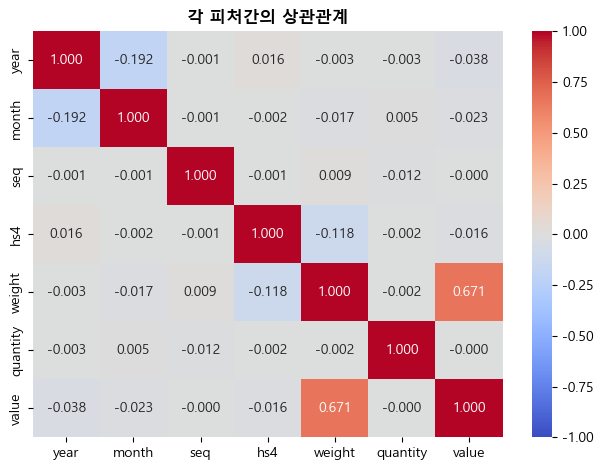

In [10]:
heat_df = df.drop(columns=['item_id', 'type', '2단위', '4단위', 'ym']).corr()
sns.heatmap(data=heat_df, annot=True, fmt='.3f', vmin=-1, vmax=1, cmap='coolwarm')
plt.title('각 피처간의 상관관계', weight='bold')
plt.tight_layout()
plt.show()

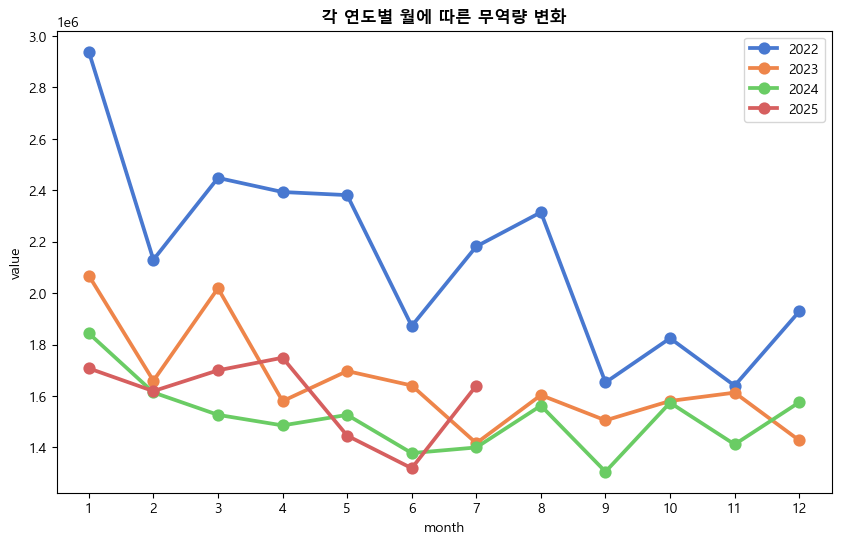

In [11]:
# 각 월에 따른 무역량 변화
fig = plt.figure(figsize=(10,6))
sns.pointplot(data=df, x='month', y='value',
            hue='year', palette='muted',errorbar=None)
plt.title('각 연도별 월에 따른 무역량 변화', weight='bold')
plt.legend()
plt.show()

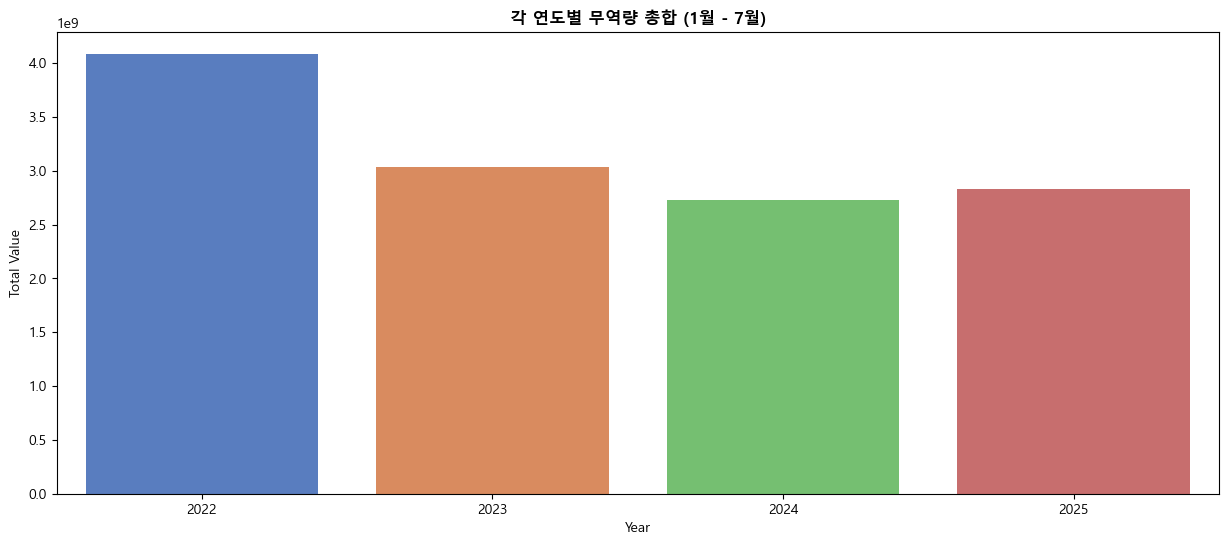

In [12]:
year_value = df[df['month'] <= 7].groupby('year')['value'].sum() 

plt.figure(figsize=(15, 6))

sns.barplot(x=year_value.index,
            y=year_value.values,
            palette='muted',       
            hue=year_value.index,
            legend=False)

plt.title('각 연도별 무역량 총합 (1월 - 7월)', weight='bold')
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.show()

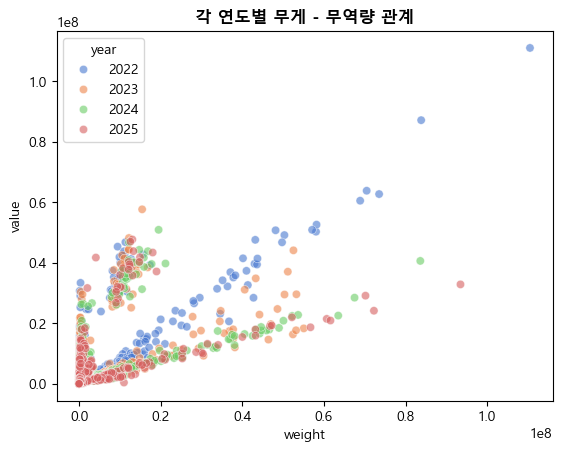

In [13]:
sns.scatterplot(data=df, x='weight', y='value', alpha=0.6, hue='year', palette='muted')
plt.title('각 연도별 무게 - 무역량 관계', weight='bold')
plt.show()

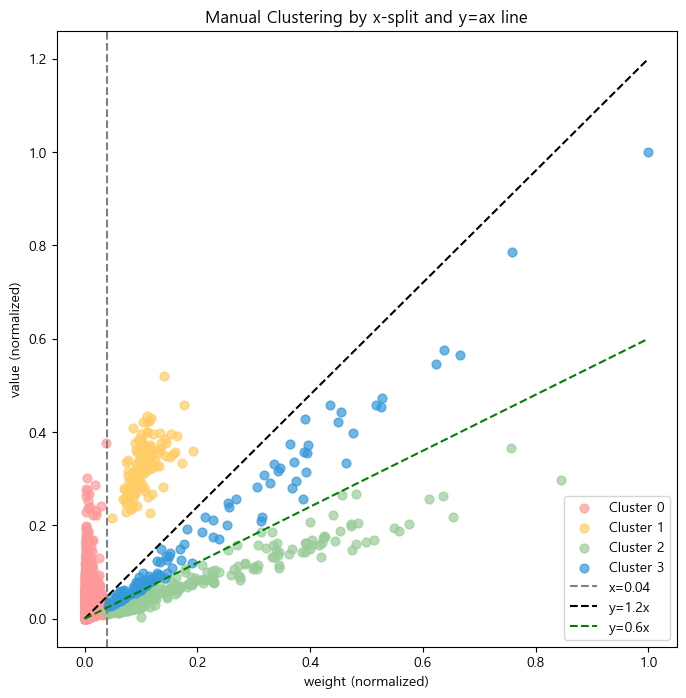

In [14]:
# 최대 weight 값 기준 정규화
x = df['weight'] / df['weight'].max()
y = df['value'] / df['value'].max()

# 기준선 설정
x_split = 0.04     # x=0.3 경계선
a = 1.2            # y = a*x 기준선 (기울기)
b = 0.6            # y = b*x 기준선 (기울기)
df['cluster_manual'] = 0  # 기본값

# 조건별 군집 분류
df.loc[(x <= x_split), 'cluster_manual'] = 0 # 분홍색 군집
df.loc[(x > x_split) & (y > a * x), 'cluster_manual'] = 1 # 노란색 군집
df.loc[(x > x_split) & (y <= a * x), 'cluster_manual'] = 2 # 초록색 군집
df.loc[(x > x_split) & (y <= a * x) & (y >= b * x), 'cluster_manual'] = 3 # 파란색 군집

# 시각화
plt.figure(figsize=(8,8))
colors = ['#FF9999','#FFCC66','#99CC99', '#3498db']
for i, color in enumerate(colors):
    plt.scatter(x[df['cluster_manual']==i],
                y[df['cluster_manual']==i],
                label=f'Cluster {i}', s=40, color=color, alpha=0.7)


# 기준선들 시각화
plt.axvline(x=x_split, color='gray', linestyle='--', label=f'x={x_split}')
plt.plot(np.linspace(0,1,100),
         a * np.linspace(0,1,100),
         color='black', linestyle='--', label=f'y={a}x')
plt.plot(np.linspace(0,1,100),
         b * np.linspace(0,1,100),
         color='green', linestyle='--', label=f'y={b}x')

plt.xlabel('weight (normalized)')
plt.ylabel('value (normalized)')
plt.title('Manual Clustering by x-split and y=ax line')
plt.legend()
plt.show()

In [15]:
# baseline pivot 생성
# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    df
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0)
)

pivot.head() # 2022-01 - 2025-07

ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(pivot.T).T

pivot2 = pd.DataFrame(
    index=pivot.index,
    columns=pivot.columns,
    data=data
)

In [17]:
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=12, min_nonzero=36, corr_threshold=0.35):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

pairs = find_comovement_pairs(pivot)
print("탐색된 공행성쌍 수:", len(pairs))
pairs.head()

100it [00:10,  9.54it/s]

탐색된 공행성쌍 수: 3001


,leading_item_id,following_item_id,best_lag,max_corr
0,AHMDUILJ,APQGTRMF,6,0.419733
1,AHMDUILJ,ATLDMDBO,4,0.483281
2,AHMDUILJ,AXULOHBQ,9,0.391992
3,AHMDUILJ,BJALXPFS,10,0.574470
4,AHMDUILJ,BSRMSVTC,12,0.479705


In [18]:
# 전체 item_id
U = set(df['item_id'])

#pairs에 포함된 item_id
A = set(pairs['leading_item_id'].unique()) | set(pairs['following_item_id'].unique())

# pairs에 포함되지 않은 item_id
item_list = list(U-A)
print(len(item_list))
print(item_list)

19
['OGAFEHLU', 'KFQSHBNH', 'MIRCVAMV', 'RUVXNNVA', 'QSDCUCLB', 'NAQIHUKZ', 'ANWUJOKX', 'GIKPEWTY', 'PYZMVUWD', 'FWUCPMMW', 'TGOELCAG', 'TANNMIMB', 'AANGBULD', 'BLANHGYY', 'RJCAXSGH', 'XIIEJNEE', 'GMBFCMIU', 'PLMZALFA', 'DJBLNPNC']


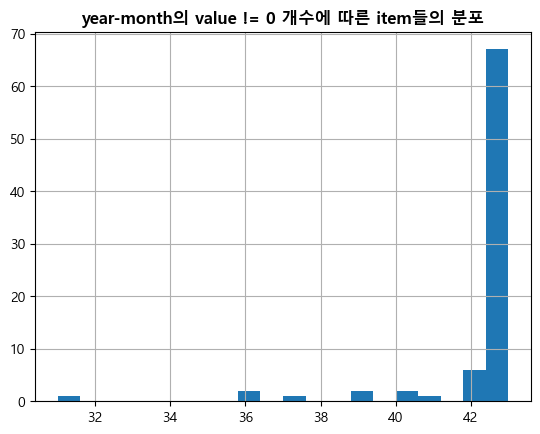

In [24]:
nonzero_counts = (pivot != 0).sum(axis=1)
nonzero_counts[nonzero_counts > 30].hist(bins=20)
plt.title('year-month의 value != 0 개수에 따른 item들의 분포', weight='bold')
plt.show()

In [20]:
pairs.sort_values(by='max_corr', key=abs)

,leading_item_id,following_item_id,best_lag,max_corr
1501,LTOYKIML,OJIFIHMZ,2,0.350038
266,BSRMSVTC,GYHKIVQT,7,0.350102
1320,KJNSOAHR,YSYHGLQK,9,-0.350113
161,AXULOHBQ,STZDBITS,8,0.350146
2624,WHPUAOID,WQMVCOEM,2,-0.350210
...,...,...,...,...
1858,QVLMOEYE,DNMPSKTB,7,0.833319
1810,QRKRBYJL,DNMPSKTB,7,0.842065
2783,XUOIQPFL,QVLMOEYE,5,0.842610
1831,QRKRBYJL,QVLMOEYE,2,0.844230
